In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from tqdm import tqdm
from glob import glob
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout, Activation, Input, Concatenate
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import copy
from keras.regularizers import l2, l1
from keras.utils import to_categorical

In [ ]:
train = pd.read_csv('/content/drive/My Drive/Files/(데이콘)컴퓨터비전/train.csv')

train_X = train.values[:,3:].reshape(-1, 28, 28, 1).astype(np.float64)
train_y = to_categorical(train.values[:,1])

print(train_X.shape)
print(train_y.shape)

(2048, 28, 28, 1)
(2048, 10)


In [ ]:
train_x1 = copy.deepcopy(train_X) 
train_x2 = copy.deepcopy(train_X) 
train_x3 = copy.deepcopy(train_X) 

train_x1 -= 128
train_x1[train_x1 < 0] = 0
train_x2 -= 112
train_x2[train_x2 < 0] = 0
train_x3 -= 170
train_x3[train_x3 < 0] = 0

train_x = np.concatenate((train_x1, train_x2, train_x3), axis=3)


# train_x = copy.deepcopy(train_X)
# v = 64
# n = 255
# train_x -= v
# n -= v
# train_x[train_x < 0] = 0
# train_x /= n

# for i in range(1, 9):
#   temp = copy.deepcopy(train_X)
#   temp -= v + i*8
#   temp[temp < 0] = 0
#   temp /= n - i*8
#   train_x = np.concatenate((train_x, temp), axis=3)

    
print(train_x.shape)

(2048, 28, 28, 3)


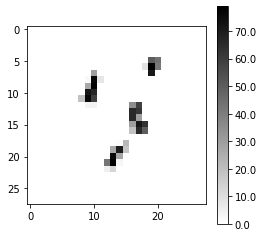

In [ ]:
plt.figure(1, figsize=(4, 4))
# plt.imshow(train_data[2030], cmap=plt.cm.gray_r, interpolation='nearest')
plt.imshow(train_x[2030, :, :,2], cmap=plt.cm.gray_r, interpolation='nearest')
plt.colorbar(format='%0.1f')
plt.show()

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

In [ ]:
def build_model():
  model = Sequential()

  model.add(Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 3), kernel_regularizer=l1(0.001)))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3,3), activation='relu', kernel_regularizer=l1(0.001)))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (5,5), strides=(2,2), activation='relu', padding='same', kernel_regularizer=l1(0.001)))
  model.add(BatchNormalization())
  model.add(Dropout(rate=0.3))
  # shape(-1, 32, 12, 12, 1)

  model.add(Conv2D(64, (3,3), activation='relu', kernel_regularizer=l1(0.001)))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3,3), activation='relu', kernel_regularizer=l1(0.001)))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (5,5), strides=(2,2), activation='relu', padding='same', kernel_regularizer=l1(0.001)))
  model.add(BatchNormalization())
  model.add(Dropout(rate=0.3))
  # shape(-1, 64, 4, 4, 1)

  model.add(Conv2D(128, (4,4), activation='relu', kernel_regularizer=l1(0.001)))
  model.add(BatchNormalization())
  # shape(-1, 128, 1, 1, 1)

  model.add(Flatten()) # shape(-1, 512)
  model.add(Dropout(rate=0.3))

  model.add(Dense(10, activation='softmax'))

  model.compile(loss=tf.keras.losses.KLDivergence(), optimizer='adam', metrics = ['accuracy'])
  # model.compile(
  #     loss=tf.keras.losses.sparse_categorical_crossentropy,
  #     optimizer=tf.keras.optimizers.SGD(learning_rate=0.003),
  #     metrics=['accuracy'])
  model.summary()
  
  return model


model1 = build_model()

In [ ]:
!rm -r /content/model

# 모델 폴더를 생성합니다.
model_path = 'model/'
if not os.path.exists(model_path):
  os.mkdir(model_path)

# Validation 점수가 가장 좋은 모델만 저장합니다.
model_file_path = model_path + 'Epoch_{epoch:03d}_Val_{val_loss:.3f}.hdf5'
checkpoint = ModelCheckpoint(filepath=model_file_path, monitor='val_loss', verbose=1, save_best_only=True)

# 10회 간 Validation 점수가 좋아지지 않으면 중지합니다.
early_stopping = EarlyStopping(monitor='val_loss', patience=10)



tra_x, val_x, tra_y, val_y = train_test_split(
    train_x, train_y, test_size = 0.2, shuffle=True)



# 모델을 학습시킵니다.
history = model1.fit(
    # train_x, train_y,
    datagen.flow(tra_x, tra_y, batch_size=128), 
    epochs=100, 
    batch_size=1, 
    # validation_split=0.2, 
    # shuffle=True,
    validation_data=(val_x, val_y), 
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/100
13/13 [==============================] - ETA: 0s - loss: 11.5524 - accuracy: 0.1447
Epoch 00001: val_loss improved from inf to 10.72059, saving model to model/Epoch_001_Val_10.721.hdf5
13/13 [==============================] - 2s 148ms/step - loss: 11.5524 - accuracy: 0.1447 - val_loss: 10.7206 - val_accuracy: 0.2122
Epoch 2/100
13/13 [==============================] - ETA: 0s - loss: 10.8744 - accuracy: 0.2228
Epoch 00002: val_loss did not improve from 10.72059
13/13 [==============================] - 1s 107ms/step - loss: 10.8744 - accuracy: 0.2228 - val_loss: 12.0173 - val_accuracy: 0.2585
Epoch 3/100
13/13 [==============================] - ETA: 0s - loss: 10.6031 - accuracy: 0.2570
Epoch 00003: val_loss did not improve from 10.72059
13/13 [==============================] - 1s 105ms/step - loss: 10.6031 - accuracy: 0.2570 - val_loss: 12.0622 - val_accuracy: 0.1829
Epoch 4/100
13/13 [==============================] - ETA: 0s - loss: 10.2819 - accuracy: 0.2778
Epoch 00004:

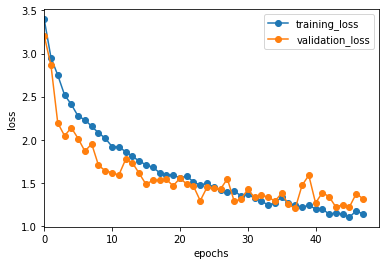

In [ ]:
# 훈련 결과를 확인합니다.
plt.plot(history.epoch, history.history['loss'], '-o', label='training_loss')
plt.plot(history.epoch, history.history['val_loss'], '-o', label='validation_loss')
plt.legend()
plt.xlim(left=0)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

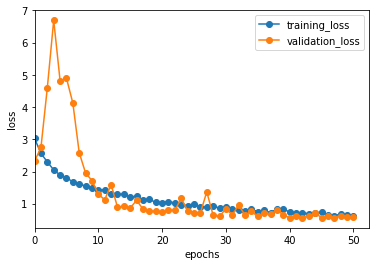

In [ ]:
# 훈련 결과를 확인합니다.
plt.plot(history.epoch, history.history['loss'], '-o', label='training_loss')
plt.plot(history.epoch, history.history['val_loss'], '-o', label='validation_loss')
plt.legend()
plt.xlim(left=0)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
test = pd.read_csv('/content/drive/My Drive/Files/(데이콘)컴퓨터비전/test.csv')

test_X = test.values[:,2:].reshape(-1, 28, 28,1)
test_X = test_X.astype(np.float64)
# test_x[test_x < 128] = 0

In [ ]:
# test_x1 = copy.deepcopy(test_x) 
# test_x2 = copy.deepcopy(test_x) 
# test_x3 = copy.deepcopy(test_x) 

# test_x -= 128
# test_x1[test_x1 < 0] = 0
# test_x2 -= 112
# test_x2[test_x2 < 0] = 0
# test_x3 -= 170
# test_x3[test_x3 < 0] = 0

# test_x = np.concatenate((test_x1, test_x2, test_x3), axis=3)



test_x = copy.deepcopy(test_X)
v = 64
n = 255
test_x -= v
n -= v
test_x[test_x < 0] = 0
test_x /= n

for i in range(1, 9):
  temp = copy.deepcopy(test_X)
  temp -= v + i*8
  temp[temp < 0] = 0
  temp /= n - i*8
  test_x = np.concatenate((test_x, temp), axis=3)

    
print(test_x.shape)

(20480, 28, 28, 9)


In [ ]:
# # 검증 wav 파일로부터 Feature를 만듭니다.
# x_test = sorted(glob('data/test/*.wav'))
# x_test = data_loader(x_test)
# x_test = x_test / 30000
# x_test = x_test[:, ::8]
# x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

# 가장 좋은 모델의 weight를 불러옵니다.
weigth_file = sorted(glob('model/*.hdf5'))[-1]
print(weigth_file)
model.load_weights(weigth_file)

# 예측 수행
y_hat = model.predict(test_x)

model/Epoch_076_Val_0.518.hdf5


In [ ]:
np.save('y_hat2', y_hat)
y_hat.shape

(20480, 10)

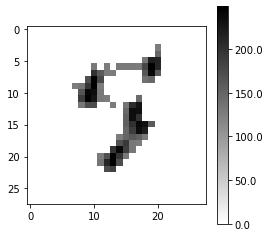

In [ ]:
plt.figure(1, figsize=(4, 4))
# plt.imshow(train_data[2030], cmap=plt.cm.gray_r, interpolation='nearest')
plt.imshow(tttt[2030], cmap=plt.cm.gray_r, interpolation='nearest')
plt.colorbar(format='%0.1f')
plt.show()

In [ ]:
y_hat0 = np.load('y_hat1.npy')
for i in range(2,4):
  y_hat0 += np.load('y_hat%d.npy'%i)


y_hat0 = y_hat0.argmax(axis=1)

In [ ]:

y_hat = y_hat.argmax(axis=1)
y_hat.shape

(20480,)

In [ ]:
# 예측 결과로 제출 파일을 생성합니다.
# submission = pd.read_csv('data/submission.csv', index_col=0)
submission = pd.read_csv('/content/drive/My Drive/Files/(데이콘)컴퓨터비전/submission.csv', index_col=0)
submission.loc[:, 'digit'] = y_hat0
submission.to_csv('submission005.csv')